## Optimization model 

In [1]:
from model import shortestPathModel

In [2]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-04-13
Using license file C:\Users\Apocrypse\gurobi.lic


In [3]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print('Obj: {}'.format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [4]:
from data import shortestpath, dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [5]:
# generate data for grid network (features and costs)
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial kernel
x, c = shortestpath.genData(n+1000, p, grid, deg=deg)

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [7]:
# get training data set
sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 377.97it/s]


In [8]:
# get training data set
sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 412.43it/s]


In [9]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 5])

In [12]:
c.shape

torch.Size([32, 40])

In [13]:
w.shape

torch.Size([32, 40])

In [14]:
z.shape

torch.Size([32, 1])

## Loss Function

In [15]:
from func import SPOPlus

In [16]:
# init SPO+ loss
criterion = SPOPlus()

## Linear Regression 

In [17]:
import torch
from torch import nn

In [18]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## Training 

In [19]:
from matplotlib import pyplot as plt

In [20]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

In [21]:
# set optimizer
optimizer = torch.optim.Adam(lr.parameters(), lr=5e-2)

In [22]:
# train model
num_epochs = 400
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = lr(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch+1, loss.item()))

epoch 10, loss:192.272568
epoch 20, loss:209.176941
epoch 30, loss:266.984344
epoch 40, loss:29.586548
epoch 50, loss:145.489792
epoch 60, loss:29.033344
epoch 70, loss:3.541790
epoch 80, loss:17.058430
epoch 90, loss:37.308788
epoch 100, loss:8.608282
epoch 110, loss:38.811169
epoch 120, loss:5.664768
epoch 130, loss:17.374430
epoch 140, loss:11.749817
epoch 150, loss:17.711752
epoch 160, loss:7.716951
epoch 170, loss:39.656551
epoch 180, loss:16.951817
epoch 190, loss:16.604370
epoch 200, loss:12.655762
epoch 210, loss:63.046459
epoch 220, loss:4.155064
epoch 230, loss:107.356453
epoch 240, loss:8.903078
epoch 250, loss:47.037708
epoch 260, loss:2.454226
epoch 270, loss:0.000003
epoch 280, loss:4.296783
epoch 290, loss:10.333696
epoch 300, loss:35.982113
epoch 310, loss:13.188059
epoch 320, loss:6.557940
epoch 330, loss:0.143017
epoch 340, loss:7.608271
epoch 350, loss:-0.000010
epoch 360, loss:2.292063
epoch 370, loss:5.347080
epoch 380, loss:4.998237
epoch 390, loss:36.448448
epoch

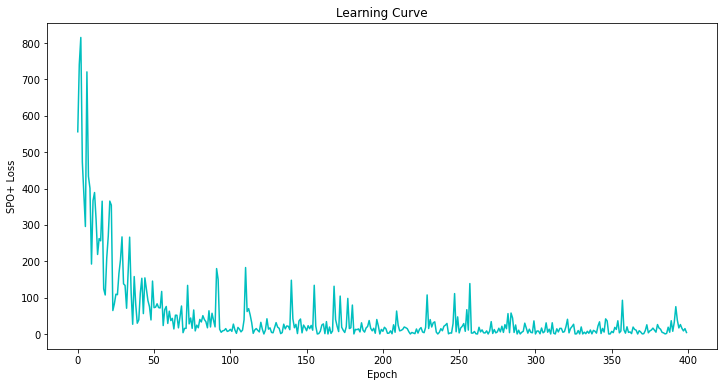

In [23]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [24]:
import numpy as np
from evalm import SPOEval

In [25]:
# evaluate
spoloss = SPOEval(lr, sp_model, sp_loader_test)
print('Normalized SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized SPO Loss: 0.42%


In [26]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -86.09, -7.60, 7.75, -0.36, 86.14, -84.83, -21.55, 6.78, -1.28, 75.02, -13.34, -98.99, -23.34, 34.14, -19.19, 63.71, -86.11, -13.95, 38.53, -24.69, -34.31, -21.72, -3.03, 45.61, 49.39, -74.89, -22.44, 6.49, 31.23, 114.10, 15.54, -16.19, 25.93, -36.32, 22.27, -4.87, -16.81, 5.84, -26.52, 5.08
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 206.94

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27

##  Training with Regularization

In [27]:
# init model
lr = LinearRegression()
# cuda
if torch.cuda.is_available():
    lr = lr.cuda()

In [28]:
# set optimizer
optimizer = torch.optim.Adam(lr.parameters(), lr=5e-2)

In [29]:
# train model
num_epochs = 400
lr.train()
loss_log = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = lr(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print('epoch {}, loss:{:.6f}'.format(epoch+1, loss.item()))

epoch 10, loss:435.812866
epoch 20, loss:188.950256
epoch 30, loss:54.736389
epoch 40, loss:27.189278
epoch 50, loss:218.383179
epoch 60, loss:211.306473
epoch 70, loss:96.737091
epoch 80, loss:44.430080
epoch 90, loss:19.324621
epoch 100, loss:29.646666
epoch 110, loss:56.940445
epoch 120, loss:15.925373
epoch 130, loss:9.182632
epoch 140, loss:5.236084
epoch 150, loss:12.503305
epoch 160, loss:18.873005
epoch 170, loss:10.091366
epoch 180, loss:4.810089
epoch 190, loss:22.246778
epoch 200, loss:17.075768
epoch 210, loss:64.376740
epoch 220, loss:41.907444
epoch 230, loss:12.115189
epoch 240, loss:6.067026
epoch 250, loss:9.341072
epoch 260, loss:23.970221
epoch 270, loss:9.893564
epoch 280, loss:22.652517
epoch 290, loss:3.605138
epoch 300, loss:8.642661
epoch 310, loss:11.656921
epoch 320, loss:42.989876
epoch 330, loss:45.268669
epoch 340, loss:75.793785
epoch 350, loss:29.151173
epoch 360, loss:26.443237
epoch 370, loss:7.588282
epoch 380, loss:12.363247
epoch 390, loss:21.268200


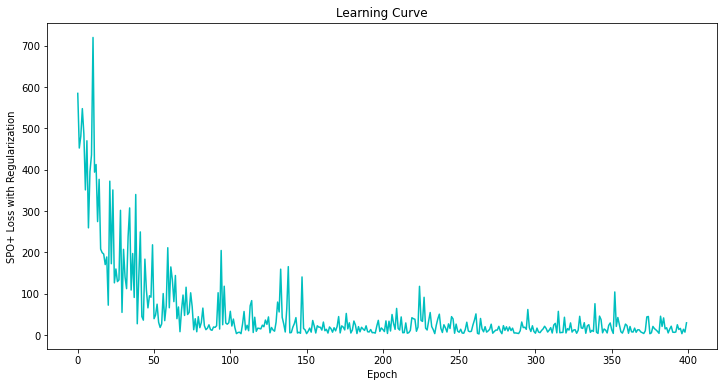

In [30]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss with Regularization')
plt.title('Learning Curve')
plt.show()

## Evaluation 

In [31]:
# evaluate
spoloss = SPOEval(lr, sp_model, sp_loader_test)
print('Normalized SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized SPO Loss: 0.47%


In [32]:
# compare solutions
lr.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = lr(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -92.12, -10.04, 8.83, 4.04, 92.38, -91.70, -23.11, -21.29, 6.38, 72.74, -10.28, -88.03, -40.03, 27.52, -24.41, 64.92, -90.76, -12.42, 39.79, -24.00, -32.21, -21.70, -8.95, 38.51, 60.61, -76.40, -24.75, -0.11, 36.64, 110.71, 20.20, -17.82, 15.60, -36.29, 34.77, 4.09, -22.19, 1.68, -37.36, 2.20
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 206.94

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.2